In [1]:
import pandas as pd
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as mpplt
import matplotlib.patches as mplpch
import matplotlib.colors as mplcol
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
%matplotlib inline

In [21]:
# load data
import scipy.io as io
# load data
data = io.loadmat('P2c_train_data_20D.mat')
train = data['x']
data = io.loadmat('P2c_test_data_20D.mat')
test = data['x']

# constants
NUM_TRAIN = train.shape[0]
NUM_TEST = test.shape[0]
NUM_ITERS = 20
NUM_FEATS = 20
NUM_SAMPLES = 300
CHOOSE_FEATS = np.random.randint(0,20,15)

# create train and test set
train_X = train[:,0:NUM_FEATS]
train_y = train[:,20].astype('int')
test_X = test[:,0:NUM_FEATS]
test_y = test[:,20].astype('int')

# random feature sampling
# train_X = train[:,CHOOSE_FEATS]
# train_y = train[:,20].astype('int')
# test_X = test[:,CHOOSE_FEATS]
# test_y = test[:,20].astype('int')

# get indices of examples corresponding to different classes
l1_idx = np.asarray([i for i in range(len(train_y)) if train_y[i] == 1], dtype='int')
l2_idx = np.asarray([i for i in range(len(train_y)) if train_y[i] == -1], dtype='int')


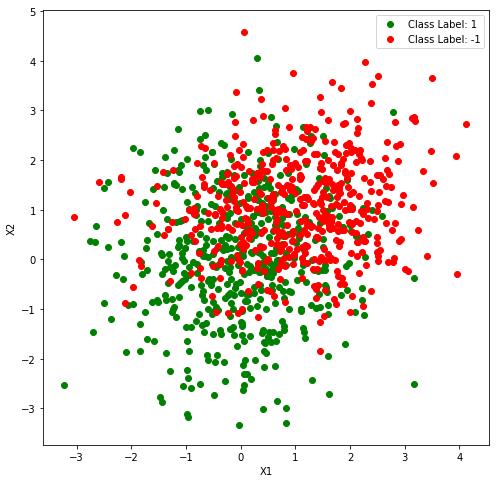

In [3]:
# plot the data points
fig = mpplt.figure(figsize=(8,8))
mpplt.scatter(train_X[l1_idx,0], train_X[l1_idx,1], c='g', label='Class Label: 1')
mpplt.scatter(train_X[l2_idx,0], train_X[l2_idx,1], c='r', label='Class Label: -1')
mpplt.xlabel('X1')
mpplt.ylabel('X2')
mpplt.legend()
mpplt.savefig('q131.pdf')

### 1.a. Bayes' Classifier

In [5]:
# compute classifier accuracy
def get_accuracy(y, y_hat):
  return np.float64(sum(y == y_hat)) / np.float64(y.size)

# compute ML estimate for Gaussian
def mle_gaussian(X):
  mu = np.mean(X, axis=0)
  sigma = np.matmul((X - mu).T, (X - mu)) / X.shape[0]

  return [mu, sigma]

# construct normal density
def gaussian_density(X, mu, sigma):
  y = linalg.multi_dot([(X - mu).T, linalg.inv(sigma), (X - mu)]) / 2
  return np.exp(-y) / (2 * np.pi * np.sqrt(linalg.det(sigma)))

# classify examples using a Bayes' classifier
def bayes_classifier(test_X, test_y, params):
  pred_y = []
  mu_1, sigma_1 = params[0][0], params[0][1]
  mu_2, sigma_2 = params[1][0], params[1][1]
    
  # predict result for each X using a Bayes' Classifier
  for X in test_X:
    q_1 = gaussian_density(X, mu_1, sigma_1)
    q_2 = gaussian_density(X, mu_2, sigma_2)
    
    if(q_1 >= q_2):
      pred_y.append(1)
    else:
      pred_y.append(-1)
    
  return get_accuracy(test_y, pred_y)

# knn classifier
def knn(train_X, train_y, test_X, test_y):
  knc = KNeighborsClassifier(n_neighbors=5)
  model = knc.fit(train_X, train_y)
  pred_y = model.predict(test_X)
  
  return get_accuracy(test_y, pred_y)


In [6]:
# draw gaussian densities
def make_ellipses(params):
  # create figure
  fig = mpplt.figure(figsize=(16,16))
  ax = mpplt.gca()
  c_colors = ['g','r']
  labels = ['Density - Class: 1', 'Density - Class: -1']
  nclass = 0
  
  # plot both gaussians
  for theta in params:
    centre = np.squeeze(theta[0])
    v, w = np.linalg.eigh(np.squeeze(theta[1]))
    u = w / np.linalg.norm(w)
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v *= 5 # scale ellipses by some factor
    ell = mplpch.Ellipse((centre[0], centre[1]), v[0], v[1],
                         180 + angle[nclass], color=c_colors[nclass])
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.25)
    ax.add_patch(ell)
    ax.scatter(centre[0], centre[1], c=c_colors[nclass], marker="x", s=100)
    nclass += 1
    
  ax.set_xlim(-3, 4)
  ax.set_ylim(-3, 4)
  return ax

In [13]:
# classifier
def bayes_gaussian(train_X, train_y, test_X, test_y, l1_idx, l2_idx, NUM_FEATS, NUM_TRAIN, NUM_ITERS, NUM_SAMPLES):
  bayes_acc = np.empty((NUM_ITERS,1))
  knn_acc = np.empty((NUM_ITERS,1))
  
  mu_1 = np.empty((NUM_ITERS,NUM_FEATS))
  mu_2 = np.empty((NUM_ITERS,NUM_FEATS))
  sigma_1 = np.empty((NUM_ITERS,NUM_FEATS,NUM_FEATS))
  sigma_2 = np.empty((NUM_ITERS,NUM_FEATS,NUM_FEATS))
  
  for i in range(NUM_ITERS):
    # construct minibatch by choosing NUM_SAMPLES training examples to estimate model
    l1_samples = l1_idx[np.random.randint(0, NUM_TRAIN // 2, NUM_SAMPLES)]
    l2_samples = l2_idx[np.random.randint(0, NUM_TRAIN // 2, NUM_SAMPLES)]
    
    # construct minibatch for KNN
    minibatch_samples = np.concatenate((l1_samples, l2_samples))
    train_X_minibatch = train_X[minibatch_samples]
    train_y_minibatch = train_y[minibatch_samples]
    
    # use ML estimate to compute parameters
    mu_1[i], sigma_1[i] = mle_gaussian(train_X[l1_samples])
    mu_2[i], sigma_2[i] = mle_gaussian(train_X[l2_samples])

    # train and predict
    bayes_acc[i] = bayes_classifier(test_X, test_y, [[mu_1[i], sigma_1[i]], [mu_2[i], sigma_2[i]]])
    knn_acc[i] = knn(train_X_minibatch, train_y_minibatch, test_X, test_y)
  
  print("NB: %f, KNN: %f" % (np.mean(bayes_acc), np.mean(knn_acc)))
  return [[mu_1, sigma_1], [mu_2, sigma_2]]
  
theta = bayes_gaussian(train_X, train_y, test_X, test_y, l1_idx, l2_idx, NUM_FEATS, NUM_TRAIN, NUM_ITERS, NUM_SAMPLES)
print("Baye's Classifier Parameters: \n")
print("Class label ""1"": \n mu = %s \n sigma: %s \n" % (np.mean(theta[0][0], axis=0), np.mean(theta[0][1], axis=0)))
print("Class label ""-1"": \n mu = %s \n sigma: %s" % (np.mean(theta[1][0], axis=0), np.mean(theta[1][1], axis=0)))

p_mean_1, p_mean_2 = np.mean(theta[0][0], axis=0), np.mean(theta[1][0], axis=0)
p_var_1, p_var_2 = np.mean(theta[0][1], axis=0), np.mean(theta[1][1], axis=0)

error = [abs(A_MEAN_1 - p_mean_1), abs(A_VAR_1 - p_var_1), abs(A_MEAN_2 - p_mean_2), abs(A_VAR_2 - p_var_2)]

print("Class 1 Mean Error: %r \n" % linalg.norm(error[0]),
            "\n Class 1 Sigma Error: %r \n" % linalg.norm(error[1]),
            "\n Class 2 Mean Error: %r \n" % linalg.norm(error[2]),
            "\n Class 2 Sigma Error: %r" % linalg.norm(error[3]))


F:\Programming Tools\Anaconda 2\envs\python36\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
F:\Programming Tools\Anaconda 2\envs\python36\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


NB: 0.490100, KNN: 0.940250
Baye's Classifier Parameters: 

Class label 1: 
 mu = [-0.0822095  0.015292   0.032239   0.107159   0.091112  -0.084956
 -0.0863335 -0.0869835  0.0605605 -0.0637125  0.065553  -0.013134
 -0.0378975  0.18503   -0.0088175  0.1346255 -0.111049  -0.0069835
 -0.0696005  0.191295 ] 
 sigma: [[  1.01628706e+00   1.84627437e-01  -1.78588147e-01   1.90985432e-01
   -9.50719416e-02  -2.42984339e-01   1.25316921e-01  -2.57609380e-01
   -1.52451761e-01   2.11353245e-01  -2.92358825e-01  -4.88981030e-02
   -9.91710475e-02  -3.73664306e-02   1.48373199e-01  -2.56596113e-02
   -9.45094884e-02   9.05535873e-02   3.47519693e-02  -2.14336118e-01]
 [  1.84627437e-01   1.33263261e+00   6.55151809e-02   2.18856338e-01
   -8.59497889e-02   1.20526417e-01  -2.90483058e-02   8.99468909e-02
    1.64623710e-01  -4.93215237e-02  -1.52003974e-01  -3.99790503e-01
   -8.04603965e-02  -2.73551531e-02   2.27201288e-01   4.76104367e-02
   -1.57871692e-01   4.28803515e-02  -2.70733918e-01   

NameError: name 'A_MEAN_1' is not defined

In [ ]:
# plot gaussian densities
ax = make_ellipses([[p_mean_1, p_var_1], [p_mean_2, p_var_2]])

# plot the data points
ax.scatter(train_X[l1_idx,0], train_X[l1_idx,1], c='g', label='Class Label: 1')
ax.scatter(train_X[l2_idx,0], train_X[l2_idx,1], c='r', label='Class Label: -1')
mpplt.xlabel('X1')
mpplt.ylabel('X2')
mpplt.legend()


### 1.a. Naive Bayes' Classifier

In [15]:
# compute classifier accuracy
def get_accuracy(y, y_hat):
  return np.float64(sum(y == y_hat)) / np.float64(y.size)

# classify examples using Bayes' classifier under Naive Bayes assumption
def naive_bayes(train_X, train_y, test_X, test_y):
  gnb = GaussianNB()
  model = gnb.fit(train_X, train_y)
  pred_y = model.predict(test_X)

  return [get_accuracy(test_y, pred_y), gnb.theta_, gnb.sigma_]

# knn classifier
def knn(train_X, train_y, test_X, test_y):
  knc = KNeighborsClassifier(n_neighbors=5)
  model = knc.fit(train_X, train_y)
  pred_y = model.predict(test_X)
  
  return get_accuracy(test_y, pred_y)


In [22]:
def naive_bayes_gaussian(train_X, train_y, test_X, test_y, l1_idx, l2_idx, NUM_FEATS, NUM_TRAIN, NUM_ITERS, NUM_SAMPLES):
  nb_acc = np.empty((NUM_ITERS,1))
  knn_acc = np.empty((NUM_ITERS,1))
  
  mu = np.empty((NUM_ITERS, NUM_FEATS, NUM_FEATS))
  sigma = np.empty((NUM_ITERS, NUM_FEATS, NUM_FEATS))
  
  for i in range(NUM_ITERS):
    # choose NUM_SAMPLES training examples to estimate model
    l1_samples = l1_idx[np.random.randint(0, NUM_TRAIN // 2, NUM_SAMPLES)]
    l2_samples = l2_idx[np.random.randint(0, NUM_TRAIN // 2, NUM_SAMPLES)]

    # construct minibatch
    minibatch_samples = np.concatenate((l1_samples, l2_samples))
    train_X_minibatch = train_X[minibatch_samples]
    train_y_minibatch = train_y[minibatch_samples]

  #   train and predict
    nb_acc[i],_,_ = naive_bayes(train_X_minibatch, train_y_minibatch, test_X, test_y)
    knn_acc[i] = knn(train_X_minibatch, train_y_minibatch, test_X, test_y)
  
  print("NB: %f, KNN: %f \n" % (np.mean(nb_acc), np.mean(knn_acc)))

theta = naive_bayes_gaussian(train_X, train_y, test_X, test_y, l1_idx, l2_idx, NUM_FEATS, NUM_TRAIN, NUM_ITERS, NUM_SAMPLES)


NB: 0.985050, KNN: 0.980850 



### 1.b. GMM - Expectation Maximization

In [ ]:
def get_accuracy(y, y_hat):
  return np.float64(sum(y == y_hat)) / np.float64(y.size)

# construct the estimated models
def gaussian_density(X, mu, sigma):
  y = linalg.multi_dot([(X - mu).T, linalg.inv(sigma), (X - mu)]) / 2
  return np.exp(-y) / (2 * np.pi * np.sqrt(linalg.det(sigma)))

# classify examples using a Bayes' classifier
def bayes_classifier(test_X, test_y, params):
  pred_y = []
  mu_1, sigma_1 = params[0][0], params[0][1]
  mu_2, sigma_2 = params[1][0], params[1][1]
    
  # predict result for each X using a Bayes' Classifier
  for X in test_X:
    q_1 = gaussian_density(X, mu_1, sigma_1)
    q_2 = gaussian_density(X, mu_2, sigma_2)
    
    if(q_1 >= q_2):
      pred_y.append(1)
    else:
      pred_y.append(-1)
    
  return [get_accuracy(test_y, pred_y), pred_y]


In [ ]:
# use GMM to estimate component densities
def gaussian_mixture_model(train_X, train_y, test_X, test_y):
  
  # create and fit Gaussian mixture model
  gmm = GaussianMixture(n_components=2, covariance_type='full', n_init=10, max_iter=100)
  model = gmm.fit(train_X)

  # get estimated means and covariances
  mu_1, mu_2 = model.means_[0], model.means_[1]
  sigma_1, sigma_2 = model.covariances_[0], model.covariances_[1]
  print(mu_1, mu_2, sigma_1, sigma_2)
  acc, pred_y = bayes_classifier(test_X, test_y, [[mu_1, sigma_1], [mu_2, sigma_2]])
    
  return [acc, pred_y, gmm]
    
gmm_acc, pred_y, model  = gaussian_mixture_model(train_X, train_y, test_X, test_y)

# get indices of examples corresponding to different classes in the test set using predictions
l1_idx_pred = np.asarray([i for i in range(len(pred_y)) if pred_y[i] == 1], dtype='int')
l2_idx_pred = np.asarray([i for i in range(len(pred_y)) if pred_y[i] == -1], dtype='int')
print("GMM: %f" % (np.mean(gmm_acc)))


In [ ]:
def plot_gaussian_densities(data_X, l1_idx, l2_idx, model):
  fig = mpplt.figure(figsize=(16,16))
  
  # points for making contour plot
  x = np.linspace(-3.0, 7.0)
  y = np.linspace(-3.0, 9.0)
  X, Y = np.meshgrid(x, y)
  XX = np.array([X.ravel(), Y.ravel()]).T
  Z = -model.score_samples(XX)
  Z = Z.reshape(X.shape)

  # make contour plot
  CS = mpplt.contour(X, Y, Z, norm=mplcol.LogNorm(vmin=1.0, vmax=10.0),
                   levels=np.logspace(0, 1, 20))
  CB = mpplt.colorbar(CS, shrink=0.4, extend='both')

  # plot data points
  mpplt.scatter(data_X[l1_idx,0], data_X[l1_idx,1], c='g', label='Class Label: 1')
  mpplt.scatter(data_X[l2_idx,0], data_X[l2_idx,1], c='r', label='Class Label: -1')
  
  # plot density means
  mpplt.scatter(model.means_[0][0], model.means_[0][1], c='g', marker='x')
  mpplt.scatter(model.means_[1][0], model.means_[1][1], c='r', marker='x')
  
  # axes properties and labels
  mpplt.xlabel('X1')
  mpplt.ylabel('X2')
  mpplt.title('Negative log-likelihood predicted using GMM')
  mpplt.axis('tight')
  mpplt.legend()
  mpplt.show()
  
plot_gaussian_densities(train_X, l1_idx, l2_idx, model)
# plot_gaussian_densities(test_X, l1_idx_pred, l2_idx_pred, model)
# mpplt.savefig('q122.pdf')